In [1]:
# !pip install ipywidgets

In [2]:
!pip install -U tensorly
!pip install -U tensorly-torch

In [2]:
import tltorch
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

/opt/conda/lib/python3.8/site-packages/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [5]:
def get_cifar100_transform(train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761), inplace=True)

        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    return transform

In [6]:
batch_size = 128

train_set = CIFAR100('CIFAR100', train=True, download=True,
                    transform=get_cifar100_transform(train=True))
test_set = CIFAR100('CIFAR100', train=False, download=True,
                   transform=get_cifar100_transform(train=False))
train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting CIFAR100/cifar-100-python.tar.gz to CIFAR100
Files already downloaded and verified


In [7]:
def plot_losses_epoch(loss, accuracy, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')
    axs[0][0].set_xlabel('epoch')
    axs[0][0].legend()

    axs[0][1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[0][1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[0][1].set_ylabel('accuracy')
    axs[0][1].set_xlabel('epoch')
    axs[0][1].legend()

    axs[1][0].plot(range(1, len(loss) + 1), loss)
    axs[1][0].set_ylabel('loss')
    axs[1][0].set_xlabel('batch')

    axs[1][1].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1][1].set_ylabel('accuracy')
    axs[1][1].set_xlabel('batch')

    for r_ax in axs:
        for ax in r_ax:
            ax.grid()

    plt.show()

In [33]:
def save_checkpoint(epoch, model, optimizer, train_loss, test_loss, test_accuracy, train_accuracy, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss' : test_loss,
            'test_accuracy' : test_accuracy,
            'train_accuracy' : train_accuracy
            }, path)

In [59]:
import tensorly as tl
tl.set_backend('pytorch')
from tensorly import tenalg
from tltorch.factorized_tensors import FactorizedTensor, TuckerTensor, TTTensor

def transform_core(core, lambdas):
    l = tenalg.outer(lambdas)
    new_core = torch.nn.Parameter(core * l.to(device))
    return new_core.to(device)

def transform_tt(tt, gammas):
    new_tt = FactorizedTensor.new(shape=tt.shape, rank=tt.rank, factorization='TT')
    for i in range(len(tt.factors[:-1])):
        new_tt.factors[i] = (torch.nn.Parameter(torch.einsum('ijk,k->ijk', \
                                                             tt.factors[i].to(device), gammas[i].to(device))))
    new_tt.factors[-1] = torch.nn.Parameter(tt.factors[-1].to(device))
    return new_tt

def tttucker_rtrl(x, tucker_core, tucker_factors, training, p=0.9, q=0.9, bias=None):
    n_input = tl.ndim(x) - 1
    
    if training:
        lambdas = [torch.Tensor(np.random.binomial(1, p, size=r)) for r in tucker_core.shape]
        droppedout_core = transform_core(tucker_core, lambdas)

        droppedout_factors = []
        for i in range(len(tucker_factors)):
            if isinstance(tucker_factors[i], TTTensor):
                gammas = [torch.Tensor(np.random.binomial(1, q, size=r)) for r in tucker_factors[i].rank[1:-1]]
                droppedout_factor = transform_tt(tucker_factors[i], gammas)
                droppedout_factors.append(droppedout_factor.to_tensor().reshape(-1, droppedout_factor.shape[-1]))
            else:
                droppedout_factors.append(tucker_factors[i].to(device))
        regression_weights = tl.tucker_tensor.tucker_to_tensor((droppedout_core, droppedout_factors))
    else:
        constructed_factors = []
        for i in range(len(tucker_factors)):
            if isinstance(tucker_factors[i], TTTensor):
                constructed_factors.append(tucker_factors[i].to_tensor().reshape(-1, \
                                                                                 tucker_factors[i].shape[-1]).to(device))
            else:
                constructed_factors.append(tucker_factors[i].to(device))
        regression_weights = tl.tucker_tensor.tucker_to_tensor((tucker_core, constructed_factors))

    if bias is None:
        return tenalg.inner(x, regression_weights, n_modes=tl.ndim(x)-1)
    else:
        return tenalg.inner(x, regression_weights, n_modes=tl.ndim(x)-1) + bias

class TTTuckerRTRL(nn.Module):
    def __init__(self, input_shape, output_shape, bias=False, verbose=0,
                 rank='same', tt_ranks=None, tt_inputshapes=None, n_layers=1,
                device=None, dtype=None, p=0.9, q=0.9, **kwargs):
        super().__init__(**kwargs)
        self.verbose = verbose

        if isinstance(input_shape, int):
            self.input_shape = (input_shape, )
        else:
            self.input_shape = tuple(input_shape)
            
        if isinstance(output_shape, int):
            self.output_shape = (output_shape, )
        else:
            self.output_shape = tuple(output_shape)
        
        self.n_input = len(self.input_shape)
        self.n_output = len(self.output_shape)
        self.weight_shape = self.input_shape + self.output_shape
        self.order = len(self.weight_shape)

        if bias:
            self.bias = nn.Parameter(torch.empty(self.output_shape, device=device, dtype=dtype))
        else:
            self.bias = None

        if n_layers == 1:
            factorization_shape = self.weight_shape
        elif isinstance(n_layers, int):
            factorization_shape = (n_layers, ) + self.weight_shape
        elif isinstance(n_layers, tuple):
            factorization_shape = n_layers + self.weight_shape
        
        # initialize with decomposed normal distribution
        full_weight = torch.normal(0.0, 0.02, size=self.weight_shape)
        
        tucker_decomposition = FactorizedTensor.new(factorization_shape, rank=rank, factorization='tucker', dtype=dtype)
        tucker_decomposition.init_from_tensor(full_weight)
        self.tucker_core = torch.nn.Parameter(tucker_decomposition.core.to(device))
        if tt_inputshapes == None:
            self.tucker_factors = torch.nn.ParameterList([torch.nn.Parameter(factor).to(device) for factor in tucker_decomposition.factors])
        elif len(tt_inputshapes) != len(self.weight_shape):
            raise ValueError('tt_inputshapes should be None or have len of weight shape')
        else:
            if tt_ranks != None and len(tt_ranks) != len(self.weight_shape):
                raise ValueError('tt_ranks should be None or have len of weight shape')
            self.tucker_factors = []
            for i, factor in enumerate(tucker_decomposition.factors):
                if tt_inputshapes[i] != None and len(tt_inputshapes[i]) > 1:
                    new_shape = tuple(tt_inputshapes[i]) + (factor.shape[-1], )
                    rank = 'same' if tt_ranks == None else tt_ranks[i]
                    self.tucker_factors.append(FactorizedTensor.new(shape=new_shape,
                                                                    rank=rank, factorization='TT',
                                           device=device, dtype=dtype).init_from_tensor(torch.reshape(factor, new_shape)))
                else:
                    self.tucker_factors.append(torch.nn.Parameter(factor).to(device))
            self.tucker_factors = torch.nn.ParameterList(self.tucker_factors)
    
        self.factorization = 'tttucker'
        self.p = p
        self.q = q

    def forward(self, x):
        return tttucker_rtrl(x, self.tucker_core, self.tucker_factors, self.training, bias=self.bias, p=self.p, q=self.q)

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, p=0.9, rank='same'):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

        self.trl = TTTuckerRTRL((64, 8, 8), (100), tt_inputshapes=[[4, 4, 4], None, None, None], p=p, q=p, device=device)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.trl(out)
        return out


def resnet20(p=0.9):
    return ResNet(BasicBlock, [3, 3, 3], p=0.9)

In [61]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0", desc='Training...', train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    batch_num = 0

    for images, labels in tqdm(train_dataloader, desc=desc):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))
        accuracies += [(logits.argmax(dim=-1).to('cpu') == labels.to('cpu')).double().mean().item()]
        
        if batch_num % 50 == 0:
            plot_losses_epoch(losses, accuracies, train_losses, test_losses, train_accuracies, test_accuracies)
        batch_num += 1
        
    return losses, predicted_classes.tolist(), true_classes.tolist()


def predict(model, val_dataloader, criterion, device="cuda:3", desc='Evaluating...'):
    model.to(device)
    model.eval()

    val_losses = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    for images, labels in tqdm(val_dataloader, desc=desc):

        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        val_losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))

    return val_losses, predicted_classes.tolist(), true_classes.tolist()

In [63]:
def train(train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    train_losses = train_losses
    test_losses = test_losses
    train_accuracies = train_accuracies
    test_accuracies = test_accuracies

    for epoch in range(start_epoch, n_epochs + 1):
        train_losses_epoch, train_predicted_classes, train_true_classes = train_one_epoch(model, train_loader, criterion, optimizer, device, f'Training {epoch}/{n_epochs}', train_losses, test_losses, train_accuracies, test_accuracies)
        train_losses += [sum(train_losses_epoch) / len(train_losses_epoch)]
        train_accuracies += [(torch.Tensor(train_predicted_classes) == torch.Tensor(train_true_classes)).type(torch.DoubleTensor).mean().item()]
        
        scheduler.step(epoch)

        test_losses_epoch, test_predicted_classes, test_true_classes = predict(model, test_loader, criterion, device, f'Evaluating... {epoch}/{n_epochs}')
        test_losses += [sum(test_losses_epoch) / len(test_losses_epoch)]
        test_accuracies += [(torch.Tensor(test_predicted_classes) == torch.Tensor(test_true_classes)).type(torch.DoubleTensor).mean().item()]

        if epoch % save_epoch == 0 and epoch > 0:
            save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, train_loss=train_losses, \
                test_loss=test_losses, test_accuracy=test_accuracies, train_accuracy=train_accuracies, \
                path= save_path + f'-epoch{epoch}.pt')
    return train_losses, test_losses, train_accuracies, test_accuracies

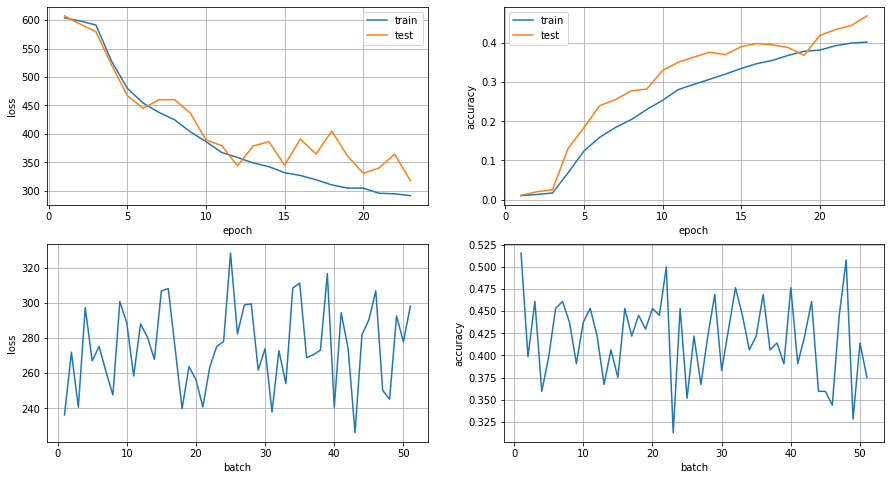

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
start_epoch = 60
p_start = 0.9
RESUME = False
criterion = nn.CrossEntropyLoss()

n_epochs = 180
save_epoch = 20
p_grid=[0.9, 0.8, 0.7, 0.6, 1]

stats = []
for p in p_grid:
    if RESUME:
        start_epoch, model, optimizer, train_losses, test_losses, train_acc, test_acc = load_checkpoint(f'RTTTRL-p-{p_start}' + f'-epoch{start_epoch}.pt', p_start)
    else:
        model = resnet20(p=p).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
        train_losses, test_losses, train_acc, test_acc = [], [], [], []
        start_epoch = 0
    save_path = f'RTTTRL-p-{p}'

    milestones = [80, 120]
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    cur_train_losses, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train(train_losses, test_losses, train_acc, test_acc)
    stats.append({'train_losses' : cur_train_losses,
                'test_losses' : cur_test_losses,
                'train_accuracies' : cur_train_accuracies,
                'test_accuracies' : cur_test_accuracies})
    RESUME = False